In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import os

print("--- Starting Latent Space Traversal ---")

# --- CONFIGURATION ---
MODEL_PATH = "/kaggle/input/cgan_200/pytorch/default/1/cgan_D1_G7_200_epochs/generator_final.pth"
OUTPUT_DIR = "/kaggle/working/Q5_traversal_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    latent_dim = 100
    embedding_dim = 100
    img_channels = 3
    features_g = 64
    num_classes = 90

config = Config()

--- Starting Latent Space Traversal ---


In [2]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim, channels_img, features_g):
        super(ConditionalGenerator, self).__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            self._block(latent_dim + embedding_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            self._block(features_g * 2, features_g, 4, 2, 1),
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False), nn.BatchNorm2d(out_c), nn.ReLU(True))
    def forward(self, z, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([z, embedding], dim=1)
        return self.net(x)

In [3]:
def slerp(v0, v1, t, DOT_THRESHOLD=0.9995):
    """Spherical linear interpolation (slerp) for PyTorch tensors."""
    v0, v1 = v0 / torch.norm(v0), v1 / torch.norm(v1)
    dot = torch.sum(v0 * v1)
    if torch.abs(dot) > DOT_THRESHOLD:
        return torch.stack([(1 - val) * v0 + val * v1 for val in t])
    theta = torch.acos(dot)
    s0, s1 = torch.sin((1 - t) * theta), torch.sin(t * theta)
    return (s0.unsqueeze(1) * v0 + s1.unsqueeze(1) * v1) / torch.sin(theta)

In [4]:
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}.")

gen = ConditionalGenerator(config.latent_dim, config.num_classes, config.embedding_dim, config.img_channels, config.features_g).to(config.device)
gen.load_state_dict(torch.load(MODEL_PATH, map_location=config.device))
gen.eval()
print(f"Generator loaded successfully from {MODEL_PATH}")

Generator loaded successfully from /kaggle/input/cgan_200/pytorch/default/1/cgan_D1_G7_200_epochs/generator_final.pth


Performing Linear Traversal...
Performing Spherical Traversal...
Plotting results...


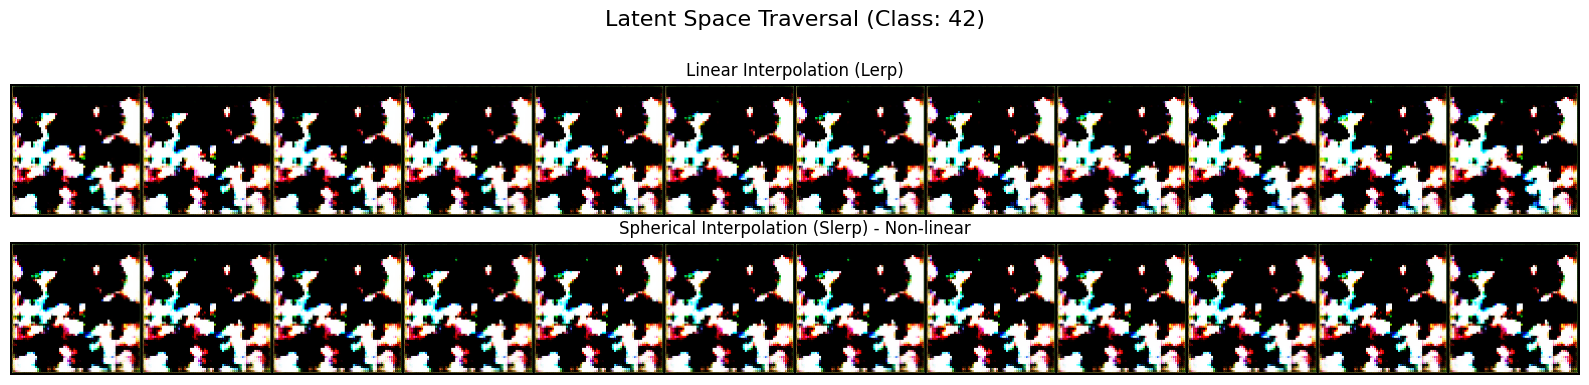

Traversal plot saved to /kaggle/working/Q5_traversal_results


In [5]:
NUM_STEPS = 12
INTERP_CLASS_LABEL = 42 # Feel free to change this class label

z1 = torch.randn(1, config.latent_dim, 1, 1, device=config.device)
z2 = torch.randn(1, config.latent_dim, 1, 1, device=config.device)
labels = torch.full((NUM_STEPS,), INTERP_CLASS_LABEL, device=config.device, dtype=torch.long)

# Linear Interpolation (Lerp)
print("Performing Linear Traversal...")
lerp_factors = torch.linspace(0, 1, NUM_STEPS, device=config.device)
z_lerp = torch.stack([(1 - alpha) * z1.squeeze() + alpha * z2.squeeze() for alpha in lerp_factors])
z_lerp = z_lerp.view(NUM_STEPS, config.latent_dim, 1, 1)
with torch.no_grad():
    lerp_images = gen(z_lerp, labels).detach().cpu()

# Spherical Interpolation (Slerp)
print("Performing Spherical Traversal...")
slerp_factors = torch.linspace(0, 1, NUM_STEPS, device='cpu')
z_slerp = slerp(z1.cpu().squeeze(), z2.cpu().squeeze(), slerp_factors).to(config.device)
z_slerp = z_slerp.view(NUM_STEPS, config.latent_dim, 1, 1)
with torch.no_grad():
    slerp_images = gen(z_slerp, labels).detach().cpu()

# Visualize
print("Plotting results...")
lerp_grid = make_grid(lerp_images, nrow=NUM_STEPS, normalize=True)
slerp_grid = make_grid(slerp_images, nrow=NUM_STEPS, normalize=True)
comparison_grid = torch.cat((lerp_grid, slerp_grid), dim=1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 4))
fig.suptitle(f"Latent Space Traversal (Class: {INTERP_CLASS_LABEL})", fontsize=16)
ax1.imshow(np.transpose(lerp_grid, (1, 2, 0)))
ax1.set_title("Linear Interpolation (Lerp)"); ax1.axis('off')
ax2.imshow(np.transpose(slerp_grid, (1, 2, 0)))
ax2.set_title("Spherical Interpolation (Slerp) - Non-linear"); ax2.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save the final comparison
save_image(comparison_grid, os.path.join(OUTPUT_DIR, "latent_space_traversals.png"))
print(f"Traversal plot saved to {OUTPUT_DIR}")